# Portfolio Analysis of Industrial sector

### Stocks under observation:

    - UPS (NYSE:UPS)
    - Boeing (NYSE:BA)
    - Rockwell Automation Inc. (NYSE:ROK)
    - Honeywell (NYSE:HON)
    - Lockheed Martin (NYSE:LMT)
    - Danaher (NYSE:DHR)


In [23]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as wb
import scipy.optimize as sco
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Pulling stock data 

In [24]:
industrial = ['UPS', 'BA', 'ROK', 'HON','LMT', 'DHR' ]
data = pd.DataFrame()
for i in range(len(industrial)):
    
    df = wb.DataReader(industrial[i], data_source='yahoo', start='2019-1-1', end = '2020-1-1')
    df['stock'] = industrial[i]
    data = data.append(df[['Adj Close', 'stock']])

table = data.pivot(columns='stock')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,BA,DHR,HON,LMT,ROK,UPS
Date,,,,,,
2019-01-02,314.645142,99.878616,127.564964,256.459991,145.874039,92.993019
2019-01-03,302.100555,97.016426,125.861893,250.017685,140.720551,90.352760
2019-01-04,317.822601,99.828918,130.264709,256.760315,145.158569,93.500038
2019-01-07,318.823395,100.236397,130.990417,259.705292,146.367188,93.184357
2019-01-08,330.891937,102.790504,130.719467,261.439392,148.281586,93.193901


Text(0, 0.5, 'price in $')

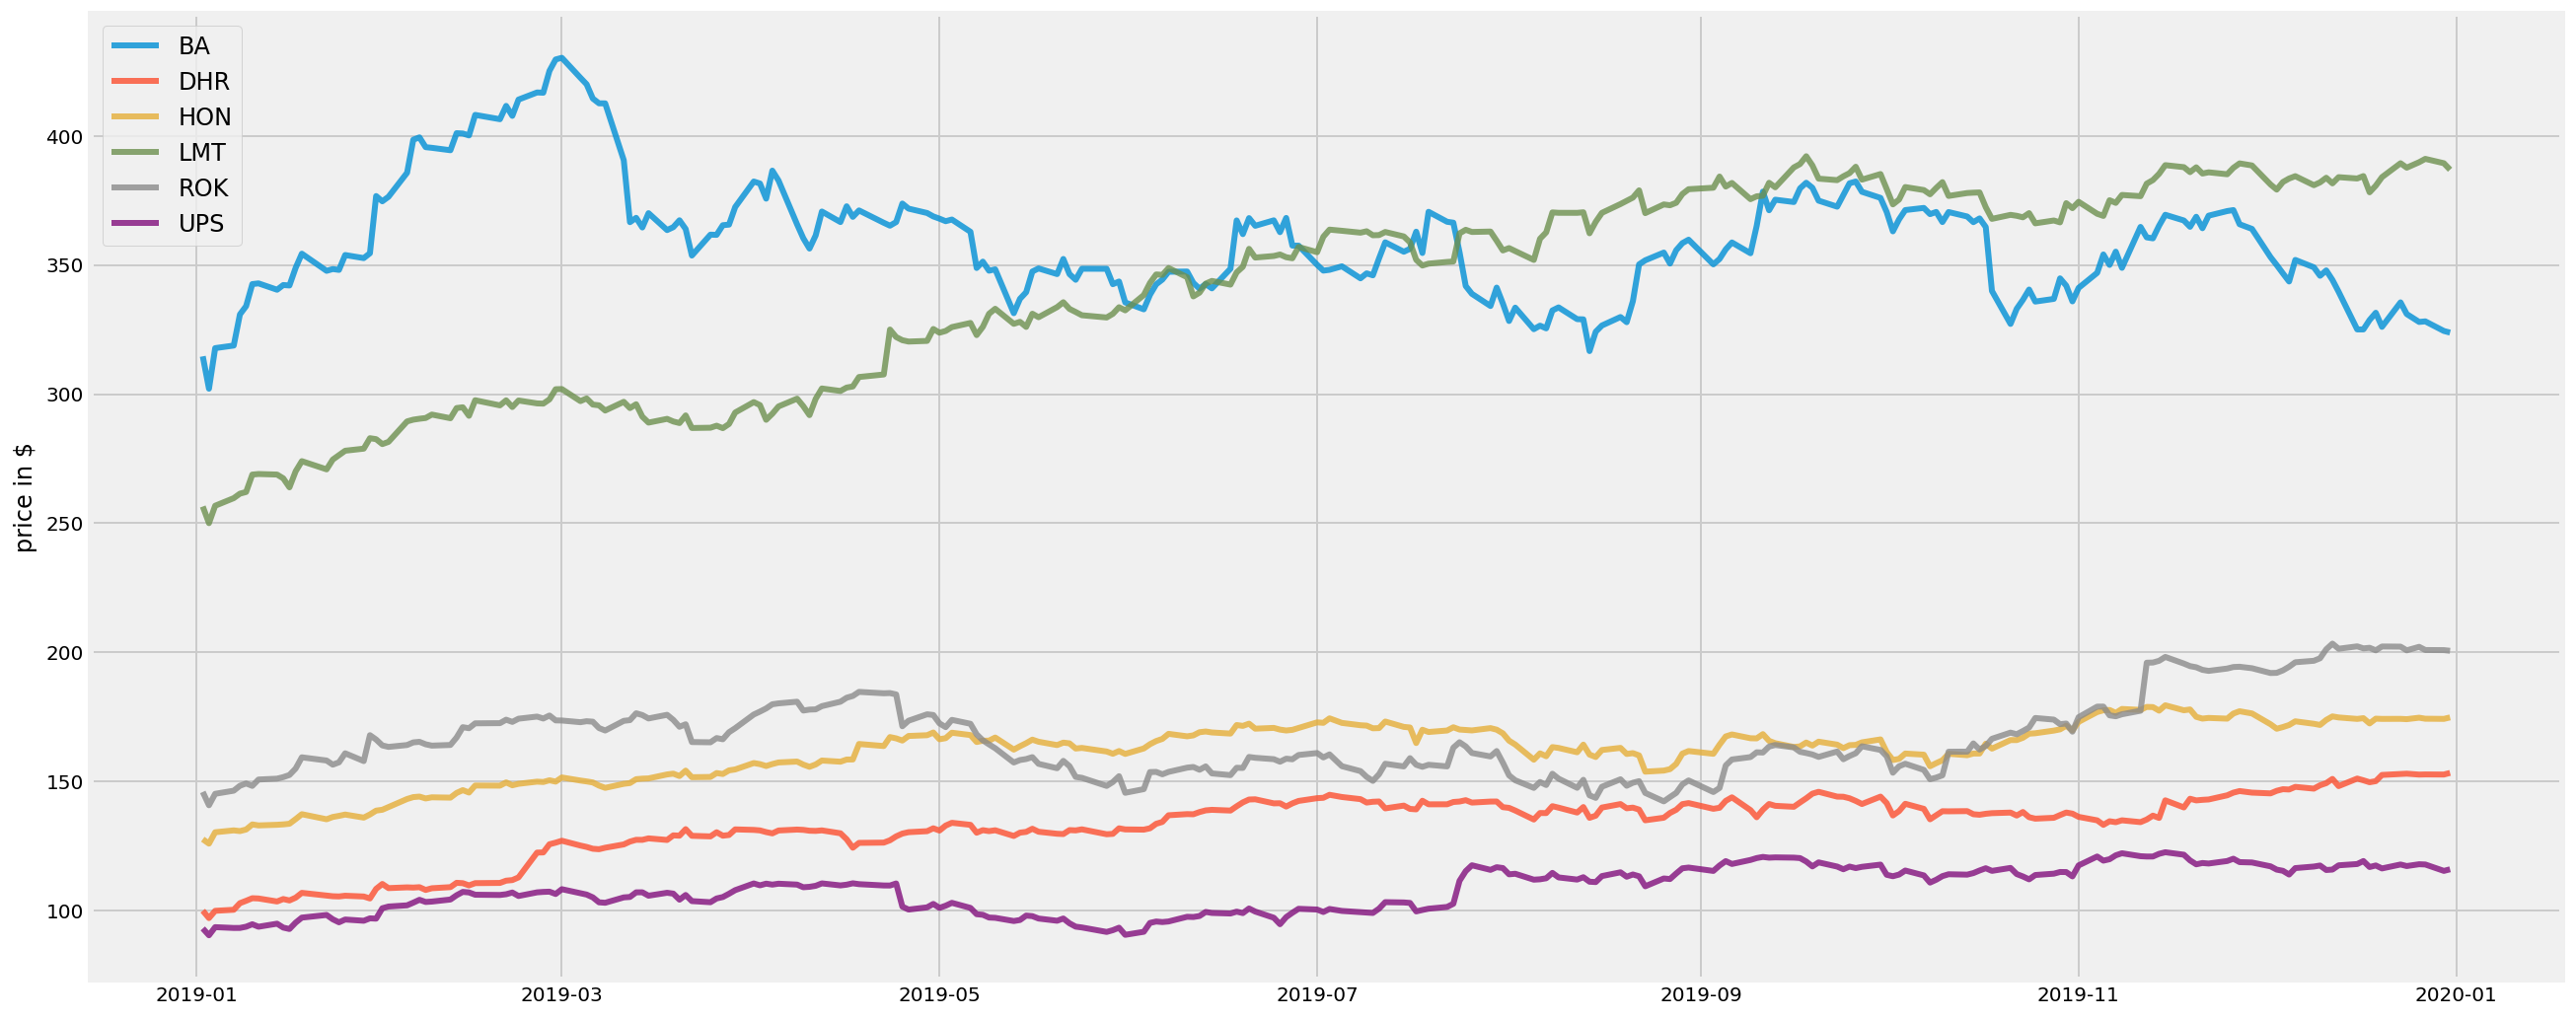

In [25]:
plt.figure(figsize=(20, 9))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

### Simple returns

Text(0, 0.5, 'daily returns')

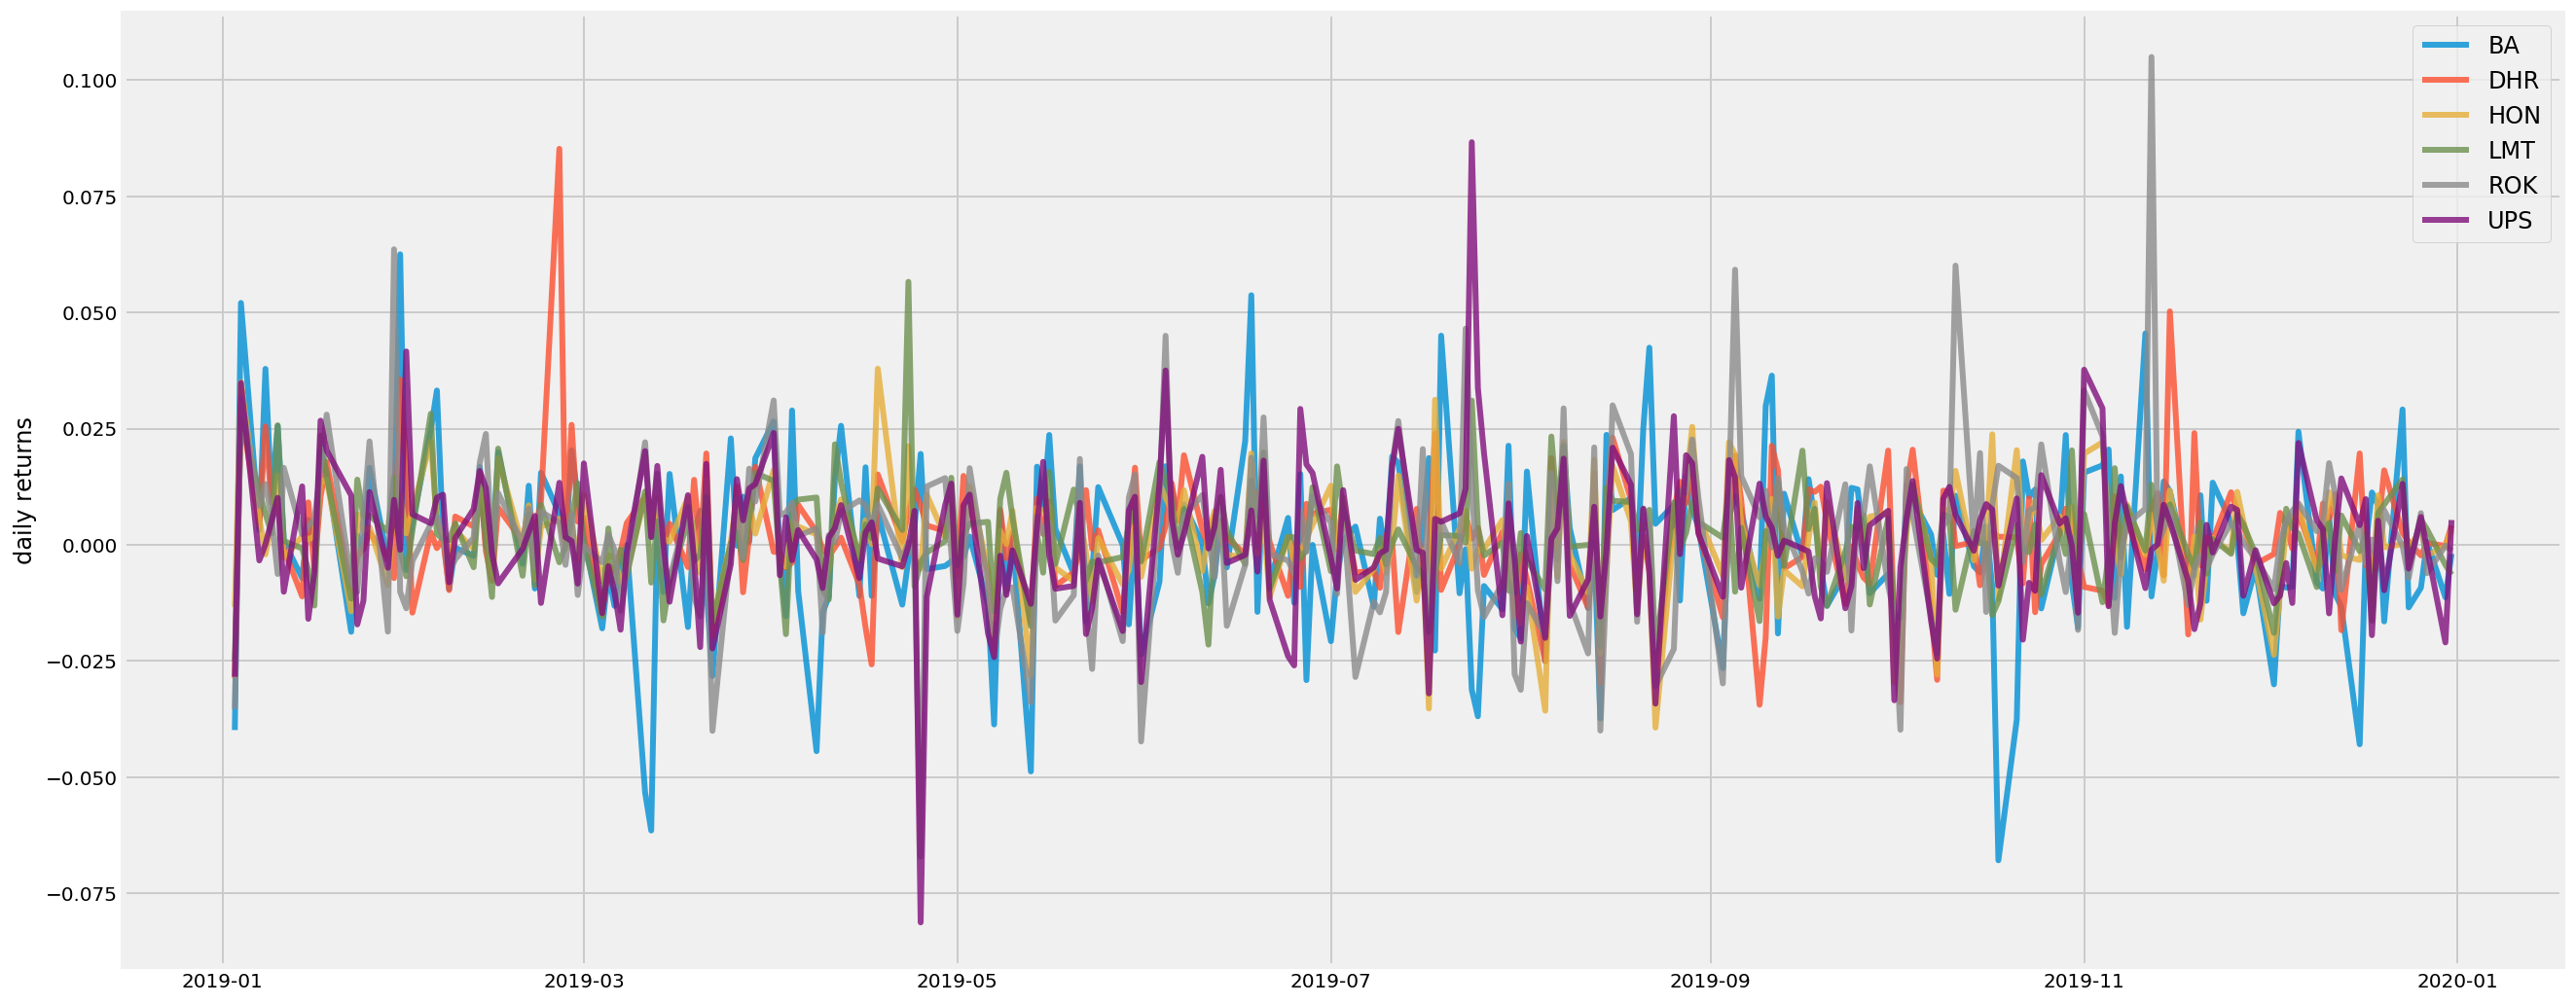

In [26]:
returns = table.pct_change()
plt.figure(figsize=(20, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

### log returns

Text(0, 0.5, 'daily log returns')

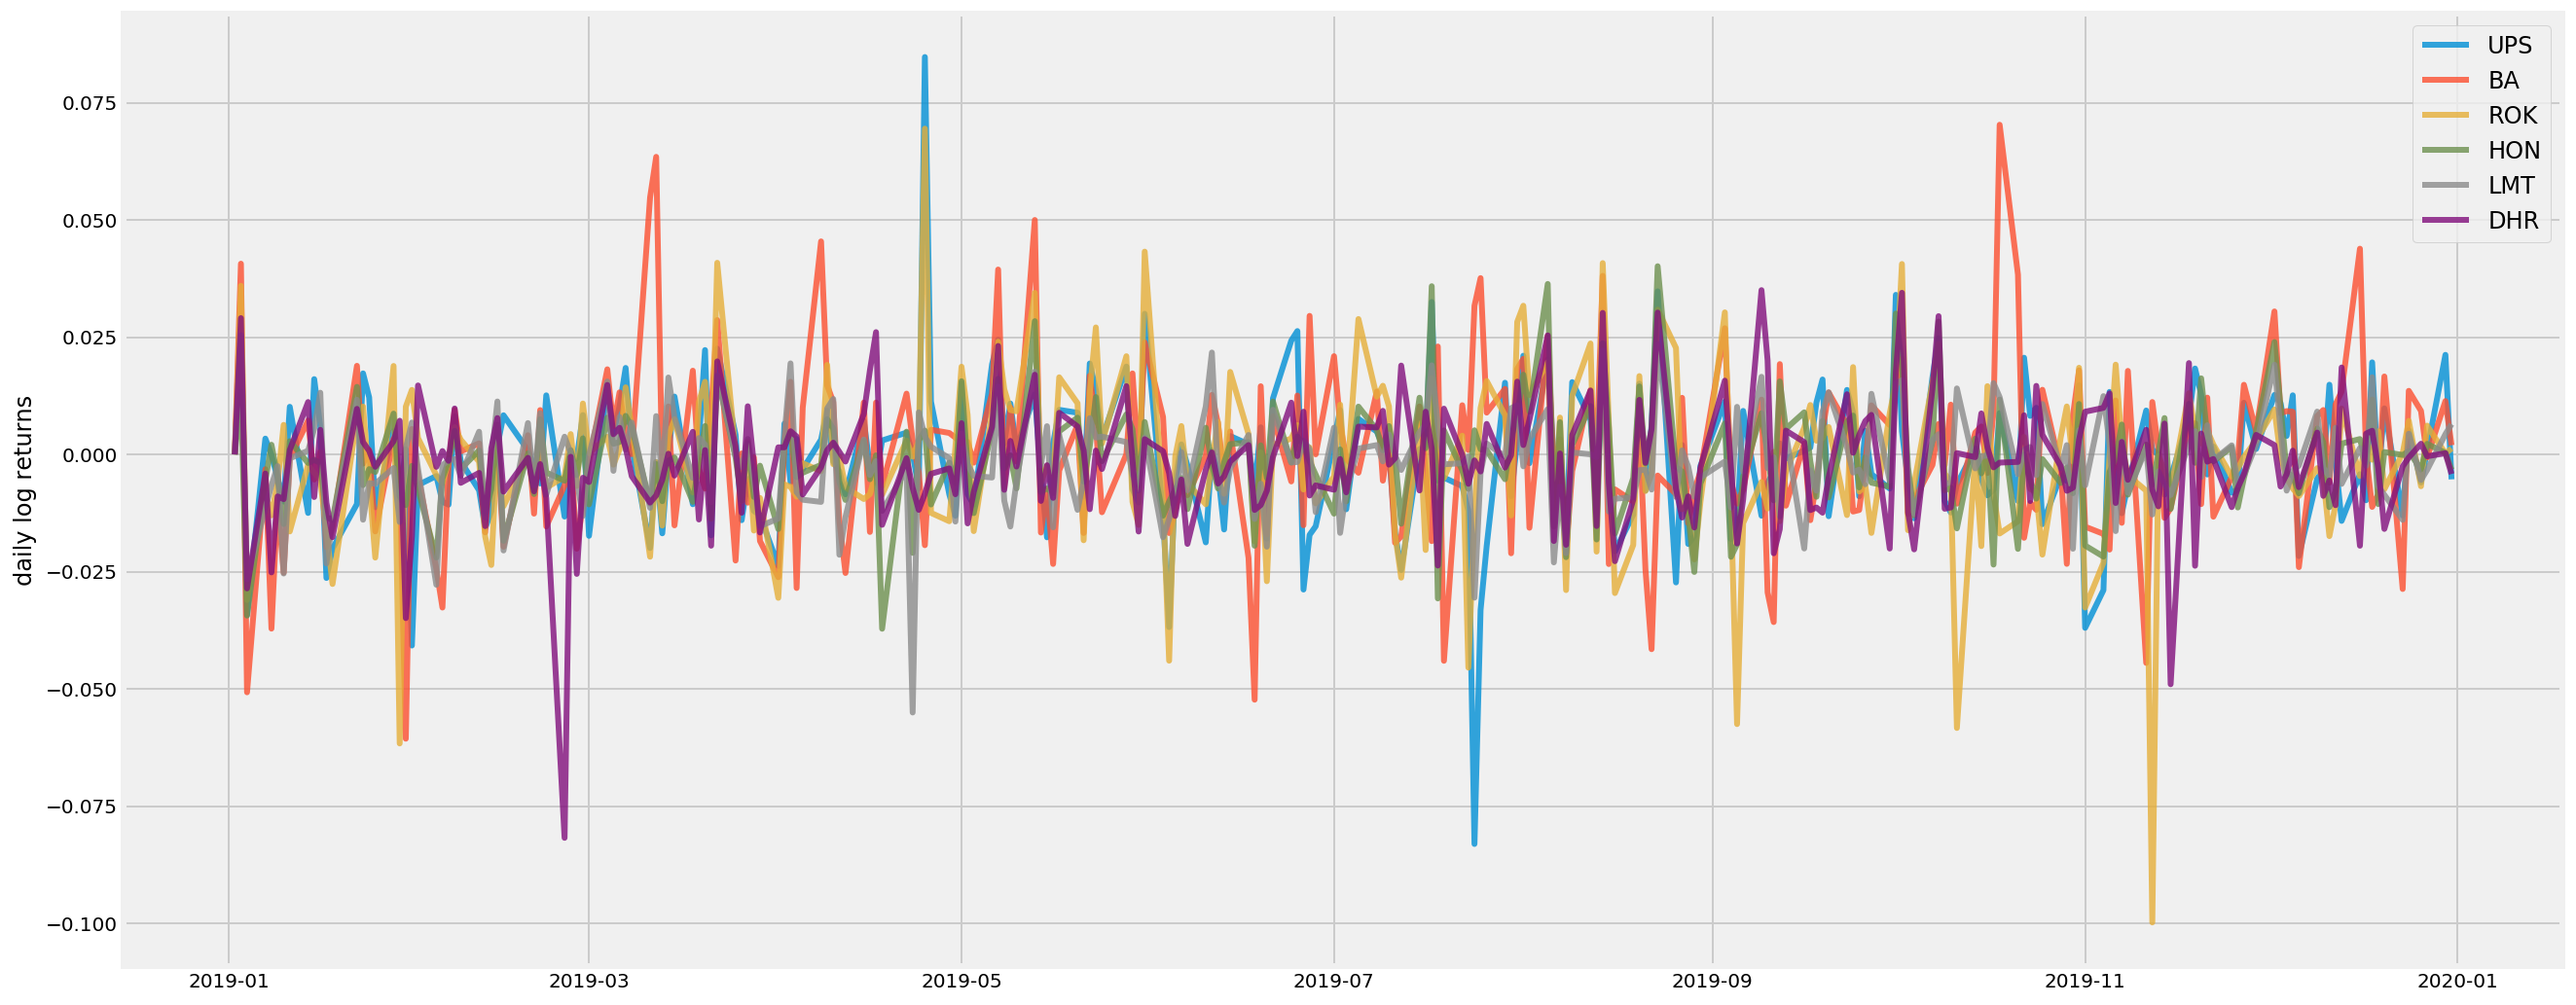

In [27]:
log = pd.DataFrame(columns = industrial, index = table.index)

for i in range(len(industrial)):
    log_list = []
    for j in range(len(table[industrial[i]])):
        if(j+1<len(table[industrial[i]])):
            log_returns =  np.log(table[industrial[i]][j]) - np.log(table[industrial[i]][j+1])
            log_list.append(log_returns)
            

        else:
            None
    log_list.insert(0, 0)   
    log[industrial[i]] = log_list


plt.figure(figsize=(20, 9))
for c in log.columns.values:
     plt.plot(log.index, log[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily log returns')


### Normalization to 100

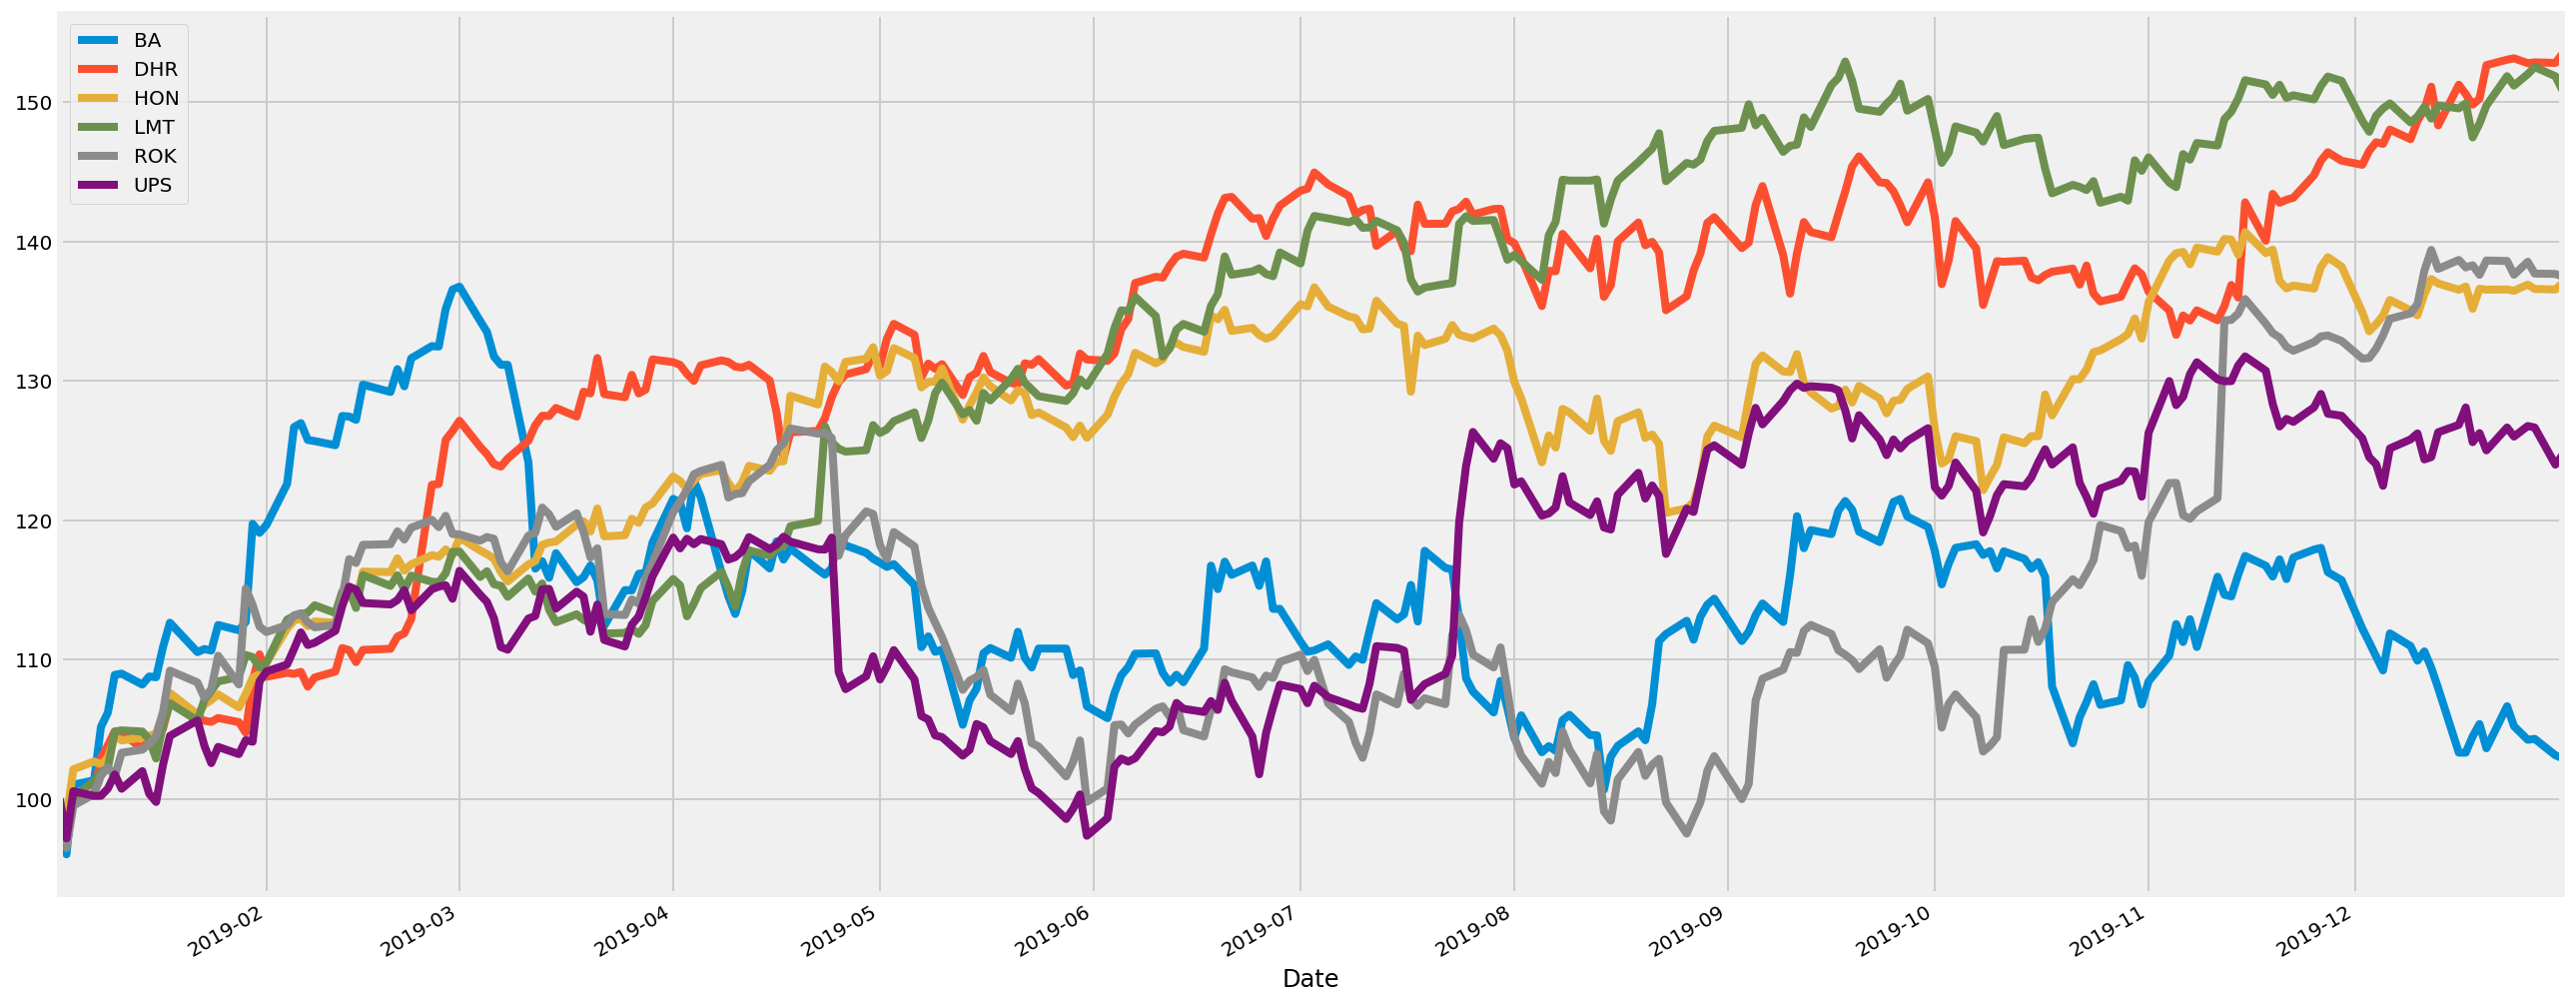

In [28]:
(table/table.iloc[0] * 100).plot(figsize = (20,9))
plt.show()

In [29]:
returns

,BA,DHR,HON,LMT,ROK,UPS
Date,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.039869,-0.028657,-0.013351,-0.025120,-0.035328,-0.028392
2019-01-04,0.052042,0.028990,0.034981,0.026969,0.031538,0.034833
2019-01-07,0.003149,0.004082,0.005571,0.011470,0.008326,-0.003376
2019-01-08,0.037853,0.025481,-0.002068,0.006677,0.013079,0.000102
...,...,...,...,...,...,...
2019-12-24,-0.013480,0.000653,-0.000680,-0.004414,-0.007146,-0.005129
2019-12-26,-0.009249,-0.002285,0.003233,0.005459,0.006804,0.006000
2019-12-27,0.000667,0.000393,-0.002261,0.003314,-0.006121,-0.000840


In [30]:
log.mean()*252

UPS   -0.220302
BA    -0.028783
ROK   -0.318397
HON   -0.314780
LMT   -0.411323
DHR   -0.428222
dtype: float64

In [31]:
log.std()*252**0.5

UPS    0.241998
BA     0.290295
ROK    0.277056
HON    0.172923
LMT    0.163945
DHR    0.201840
dtype: float64

In [32]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return(results, weights_record)

mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.02

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.41
Annualised Volatility: 0.14


             BA    DHR   HON    LMT   ROK   UPS
allocation  1.2  28.35  9.67  49.01  9.21  2.56
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.37
Annualised Volatility: 0.14


              BA    DHR    HON    LMT   ROK    UPS
allocation  6.36  20.48  21.59  37.79  3.34  10.45


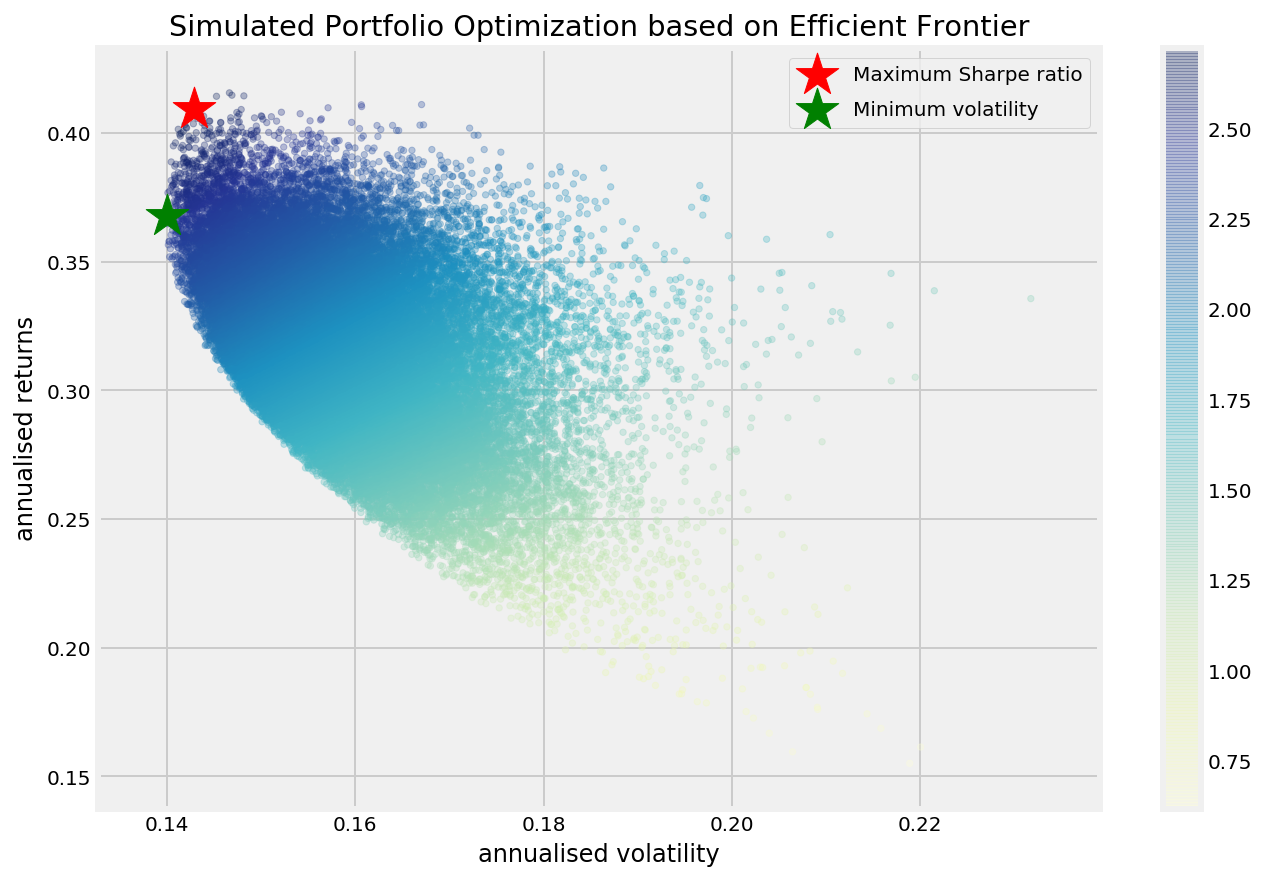

In [33]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)